In [3]:
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
import torch.nn as nn
import torch
from tqdm import tqdm

contextTokenizer = DPRContextEncoderTokenizer.from_pretrained("facebook/dpr-ctx_encoder-multiset-base")
contextModel = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-multiset-base",device_map="cuda:0")

questionTokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-multiset-base")
questionModel = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-multiset-base",device_map="cuda:0")


/home/acthegreat/miniconda3/envs/hf/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.
Some weights of the model checkpoint at facebook/dpr-ctx_encoder-multiset-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initi

In [4]:
import pandas
dfMistral = pandas.read_json("./mistral_inference.jsonl",lines=True)
dfMamba = pandas.read_csv("./mambaChat_inference_nums_0-2400.csv")

In [5]:
def dprScore(question, response):
    context = response
    input_ids = contextTokenizer(context, return_tensors="pt",truncation=True)["input_ids"]
    embeddings = contextModel(input_ids.cuda()).pooler_output
    question = question
    input_ids = questionTokenizer(question, return_tensors="pt",truncation=True)["input_ids"]
    embeddings2 = questionModel(input_ids.cuda()).pooler_output
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    output = cos(embeddings, embeddings2)
    return output

In [6]:
def generateMetrics(df,predColumnName):
    outArray = []
    metrics = {'goldenScore': 0, 'modelScore': 0, 'percentage': 0}
    for i in tqdm(range(len(df))):
        question = df.loc[i,"question"]
        gold = df.loc[i,"goldenResponse"]
        pred = df.loc[i,predColumnName]
        with torch.no_grad():
            goldenScore = dprScore(question,gold)
            metrics['goldenScore']+=goldenScore
            modelScore = dprScore(question,pred)
            metrics['modelScore']+=modelScore
            outArray.append([goldenScore,modelScore,modelScore/goldenScore])
    N = len(df)
    for k in metrics.keys():
        metrics[k] /= N
    metrics['percentage'] = metrics['modelScore'] / metrics['goldenScore']
    return metrics, outArray

In [7]:
metricsMistral,outArrayMistral = generateMetrics(dfMistral,"raw_output")
metricsMamba, outArrayMamba = generateMetrics(dfMamba,"modelOutput")
metricsMistral,metricsMamba

100%|██████████| 2399/2399 [01:05<00:00, 36.88it/s]


({'goldenScore': tensor([0.6774], device='cuda:0'),
  'modelScore': tensor([0.6727], device='cuda:0'),
  'percentage': tensor([0.9931], device='cuda:0')},
 {'goldenScore': tensor([0.6774], device='cuda:0'),
  'modelScore': tensor([0.6034], device='cuda:0'),
  'percentage': tensor([0.8908], device='cuda:0')})

In [8]:
output = []
for i in range(len(outArrayMistral)):
    if outArrayMistral[i][1]<outArrayMamba[i][1]:
        output.append([i,dfMistral.loc[i,"goldenResponse"],dfMistral.loc[i,"raw_output"],dfMamba.loc[i,"modelOutput"]])
output

[[0,
  'The music director of the Quebec Symphony Orchestra is Fabien Gabel.',
  ' Fabien Gabel\n\nExplanation:\n\nThe given context states that Fabien Gabel is the music director of the Quebec Symphony Orchestra. Therefore, the answer to the question is Fabien Gabel.',
  'Fabien Gabel is the music director of the Quebec Symphony Orchestra.'],
 [5,
  'It\'s possible to get a cash advance without a bank account through certain methods. One can use a secured credit card or a prepaid debit card to take out a cash advance. Some "cash advance" loans, often referred to as payday loans, don\'t require a bank account and will either hand you cash or put the money on a prepaid debit card. However, most traditional credit cards will require a bank account before approval.',
  ' Yes, there are some forms of "cash advance" loans that do not require a bank account, such as payday loans that distribute funds through direct deposit or by giving you cash or a prepaid debit card. However, these loans o

In [9]:
scores = [i[1].cpu().item() for i in outArrayMistral]
scores

[0.6839569807052612,
 0.719316840171814,
 0.697705864906311,
 0.7491600513458252,
 0.7075265645980835,
 0.6240096688270569,
 0.5747894048690796,
 0.7608133554458618,
 0.6799378991127014,
 0.578384518623352,
 0.7585300803184509,
 0.7065026760101318,
 0.7237303256988525,
 0.6960448622703552,
 0.6466135382652283,
 0.6723588705062866,
 0.6515219211578369,
 0.6921532154083252,
 0.7329016923904419,
 0.7136654853820801,
 0.7001416087150574,
 0.7235277891159058,
 0.6635666489601135,
 0.6220579147338867,
 0.6156368255615234,
 0.63120037317276,
 0.6208643913269043,
 0.6803399324417114,
 0.7286012768745422,
 0.7333592176437378,
 0.6975749731063843,
 0.7060092687606812,
 0.7195150256156921,
 0.6616085171699524,
 0.7591372132301331,
 0.6605188846588135,
 0.7225347757339478,
 0.6637156009674072,
 0.6401490569114685,
 0.689922571182251,
 0.7069046497344971,
 0.7130770683288574,
 0.6859864592552185,
 0.6909975409507751,
 0.7256036996841431,
 0.6285138130187988,
 0.7189147472381592,
 0.6241409778594971

In [10]:
dfMistral = dfMistral.assign(scores=scores)
dfMistral

,context,question,goldenResponse,raw_output,scores
0,"HOUSTON (Jan. 23, 2018) – Fabien Gabel, music ...",Who is the music director of the Quebec Sympho...,The music director of the Quebec Symphony Orch...,Fabien Gabel\n\nExplanation:\n\nThe given con...,0.683957
1,Port Harcourt – The Rivers police command on W...,Who were the four students of the University o...,The four students of the University of Port Ha...,The four students of the University of Port H...,0.719317
2,Channels\nMusic\nStyle\nPop Culture\nSports\nS...,What did Paul Wall offer to all U.S. Olympic M...,Paul Wall wants to give free gold grills to al...,Paul Wall offered to give free gold grills to...,0.697706
3,The crazy level at which African countries imp...,What are the main agricultural products that A...,"African countries mainly export cocoa, edible ...",The main agricultural products that African c...,0.749160
4,"CHI 2010 Workshop May 7 or 8, 2011 (final date...",What is the main goal of the CHI 2011 workshop...,The main goal of this one-day CHI 2011 worksho...,The main goal of the CHI 2011 workshop on lar...,0.707527
...,...,...,...,...,...
2394,"Fuzzy's Ultra Premium Vodka\nThe Myth, The Man...",What are some of the achievements of Fuzzy Zoe...,Fuzzy Zoeller is known for his golfing success...,Fuzzy Zoeller is a golf legend with ten wins ...,0.684229
2395,Swedish Grand Prix rider Malin Nilsson got mar...,Who did Malin Nilsson marry on 2 June 2018?,"Malin Nilsson got married to her partner, Germ...",Malin Nilsson married Steffen Wahlkamp on 2 J...,0.700670
2396,The Cracchiolo Law Library of the James E. Rog...,What is the Fellowship in Law Librarianship of...,The Fellowship in Law Librarianship is a progr...,The Fellowship in Law Librarianship is a prog...,0.708513
2397,2nd physical eMAG store opens in Mammut\nOnlin...,Where has the second physical eMAG store been ...,The second physical eMAG store has been opened...,The second physical eMAG store has been opene...,0.692535


In [11]:
outDF= dfMistral.sort_values("scores")
outDF.iloc[:100]

,context,question,goldenResponse,raw_output,scores
1662,Published\n1975\nby Rowman and Littlefield in ...,Who is one of the world's most celebrated crea...,Anthony Browne.,Anthony Browne,0.199611
1259,2012 Up & Comers: Suzanne Diaz\nSuzanne Diaz\n...,What is the organization that Suzanne Diaz sup...,The organization that Suzanne Diaz supports th...,Junior Achievement,0.221545
243,"""Non mi sento mai bene in sua presenza.""\nTran...","What does the phrase ""Non mi sento mai bene in...","The phrase ""Non mi sento mai bene in sua prese...",I don't feel well in his presence.,0.271783
578,Grand Opera brings Scottish director David Mc...,Who is the director of the Grand Opera's versi...,The director of the Grand Opera's version of J...,David McVicar,0.291847
1879,What Katie Did & Vogue Russia\nphotos: Solve S...,What brand of bullet bra is Claudia Schiffer w...,Claudia Schiffer is wearing a bullet bra from ...,What Katie Did,0.344551
...,...,...,...,...,...
1695,Ahhh… so now it’s 9am in the morning on a love...,What are the subjects the narrator has to pass...,The subjects the narrator has to pass this sem...,The narrator has to pass the following subjec...,0.573262
59,Moor of Icirrus\nBackground\nEssentially an ex...,What special event occurs in Moor of Icirrus i...,"If you have Keldeo, Cobalion, Virizion and Ter...","If you have Keldeo, Cobalion, Virizion, and T...",0.573353
818,I wouldn't like to see the ROM stripped bare -...,What can you do with DeLite Config according t...,You will be able to partition your SD Card usi...,"According to the context, DeLite Config is a ...",0.574093
1507,The Wishart Autoregressive process of multivar...,What is the Wishart Autoregressive process use...,The Wishart Autoregressive (WAR) process is a ...,The Wishart Autoregressive (WAR) process is a...,0.574133


In [20]:
# metricsMistral,metricsMamba
scoreMistral = metricsMistral["modelScore"].cpu().item()
scoreMamba = metricsMamba["modelScore"].cpu().item()
scoreGold = metricsMamba["goldenScore"].cpu().item()

bigDict = {"Gold Response": round(scoreGold,3),"Mistral-7b":round(scoreMistral,3),"MambaChat_NoRobots-2B":round(scoreMamba,3)}

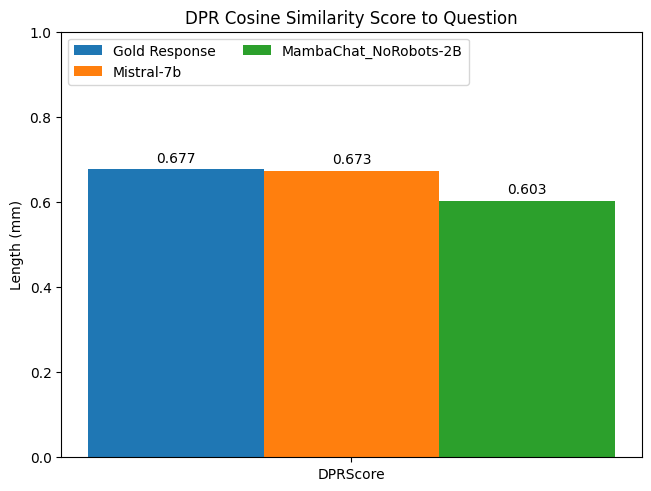

In [26]:
import matplotlib.pyplot as plt
import numpy as np

labels = (["DPRScore"])

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in bigDict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('DPR Cosine Similarity Score to Question')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 1)

# plt.show()
plt.savefig("./pic2.png")